In [2]:
# import necessary libraries
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.stem import WordNetLemmatizer
import json
import pickle

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
import random
from keras.models import load_model

# create an object of WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# importing the GL Bot corpus file for pre-processing

words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open("model/data.json").read()
intents = json.loads(data_file)

In [3]:
# preprocessing the json data
# tokenization
#nltk.download('punkt')
#nltk.download('wordnet')
for intent in intents['intents']:
    for pattern in intent['patterns']:

        #tokenize each word
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        #add documents in the corpus
        documents.append((w, intent['tag']))

        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [4]:
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

# sort classes
classes = sorted(list(set(classes)))

# documents = combination between patterns and intents
print (len(documents), "documents")

# classes = intents
print (len(classes), "classes", classes)

# words = all words, vocabulary
print (len(words), "unique lemmatized words", words)

# creating a pickle file to store the Python objects which we will use while predicting
pickle.dump(words,open('texts.pkl','wb')) 
pickle.dump(classes,open('labels.pkl','wb'))

43 documents
15 classes ['brake_issue', 'electrical_system', 'engine_problem', 'fuel_system', 'greeting', 'maintenance', 'maintenance_schedule', 'matic_issue', 'noanswer', 'oil_change', 'overheating', 'starting_issue', 'suspension', 'tire_issue', 'transmission_issue']
84 unique lemmatized words ['absorber', 'aki', 'apa', 'au', 'bagaimana', 'ban', 'berapa', 'berfungsi', 'bermasalah', 'bocor', 'brebet', 'bunyi', 'cara', 'cepat', 'dashboard', 'digunakan', 'dihidupkan', 'dinyalakan', 'ganti', 'gigi', 'goyang', 'habis', 'halo', 'harus', 'hello', 'hi', 'injeksi', 'interval', 'jadwal', 'jika', 'kapan', 'kasar', 'kenapa', 'kera', 'lakukan', 'lama', 'lampu', 'lewat', 'masalah', 'mati', 'matic', 'mau', 'mendadak', 'mengganti', 'menyala', 'merawat', 'mesin', 'mobil', 'oli', 'otomatis', 'overheat', 'pagi', 'panas', 'perawatan', 'perpindahan', 'pindah', 'polisi', 'rata', 'rem', 'responsif', 'rotasi', 'rusak', 'rutin', 'saat', 'saya', 'selamat', 'sering', 'servis', 'shock', 'siang', 'sore', 'stabil'

In [5]:
documents

[([], 'noanswer'),
 (['halo'], 'greeting'),
 (['hi'], 'greeting'),
 (['hello'], 'greeting'),
 (['selamat', 'pagi'], 'greeting'),
 (['selamat', 'siang'], 'greeting'),
 (['selamat', 'sore'], 'greeting'),
 (['mesin', 'mobil', 'brebet'], 'engine_problem'),
 (['mesin', 'mobil', 'tidak', 'stabil'], 'engine_problem'),
 (['mobil', 'tidak', 'mau', 'start'], 'starting_issue'),
 (['mobil', 'overheat'], 'overheating'),
 (['mesin', 'panas', 'saat', 'digunakan'], 'overheating'),
 (['rem', 'mobil', 'tidak', 'berfungsi'], 'brake_issue'),
 (['transmisi', 'bermasalah'], 'transmission_issue'),
 (['perpindahan', 'gigi', 'kasar'], 'transmission_issue'),
 (['mobil', 'susah', 'pindah', 'gigi'], 'transmission_issue'),
 (['transmisi', 'otomatis', 'bermasalah'], 'transmission_issue'),
 (['kapan', 'harus', 'ganti', 'oli', '?'], 'oil_change'),
 (['berapa', 'lama', 'ganti', 'oli', 'mobil', '?'], 'oil_change'),
 (['ganti', 'oli', 'mobil'], 'oil_change'),
 (['masalah', 'injeksi'], 'fuel_system'),
 (['ban', 'aus', 't

In [6]:
# create our training data
training = []

# create an empty array for our output
output_empty = [0] * len(classes)

# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
   
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)
    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])

random.shuffle(training)
training = np.array(training, dtype=object)

# create train and test lists
train_x = list(training[:,0])
train_y = list(training[:,1])

print("Training data created")

Training data created


In [7]:
# Create NN model to predict the responses
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

#fitting and saving the model 
hist = model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose=1)
model.save('models.h5', hist) # we will pickle this model to use in the future
print("\n")
print("*"*50)
print("\nModel Created Successfully!")

Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.0937 - loss: 2.6661
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0810 - loss: 2.6745     
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1714 - loss: 2.6176 
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1372 - loss: 2.6038     
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2329 - loss: 2.4680
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2346 - loss: 2.5253 
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4015 - loss: 2.3457 
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3696 - loss: 2.3800 
Epoch 9/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3662 - loss: 2.1688 
Epoch 10/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5916 - loss: 2.0748 
Epoch 11/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5384 - loss: 2.0228 
Epoch 12/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.60



**************************************************

Model Created Successfully!


In [8]:
loss, accuracy = model.evaluate(np.array(train_x), np.array(train_y), verbose=1)
print(f"Loss: {loss}, Accuracy: {accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.0026     
Loss: 0.003752914723008871, Accuracy: 1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


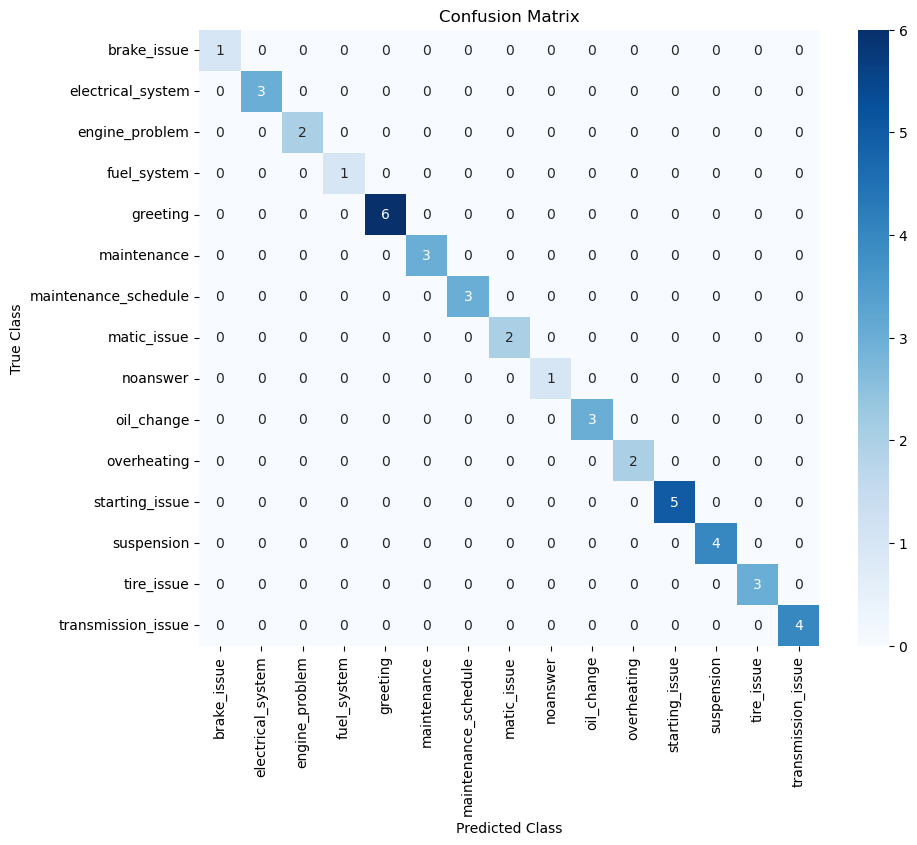

                      precision    recall  f1-score   support

         brake_issue       1.00      1.00      1.00         1
   electrical_system       1.00      1.00      1.00         3
      engine_problem       1.00      1.00      1.00         2
         fuel_system       1.00      1.00      1.00         1
            greeting       1.00      1.00      1.00         6
         maintenance       1.00      1.00      1.00         3
maintenance_schedule       1.00      1.00      1.00         3
         matic_issue       1.00      1.00      1.00         2
            noanswer       1.00      1.00      1.00         1
          oil_change       1.00      1.00      1.00         3
         overheating       1.00      1.00      1.00         2
      starting_issue       1.00      1.00      1.00         5
          suspension       1.00      1.00      1.00         4
          tire_issue       1.00      1.00      1.00         3
  transmission_issue       1.00      1.00      1.00         4

      

In [9]:
# Predicting the classes for the training data
train_predictions = model.predict(np.array(train_x))
train_pred_classes = np.argmax(train_predictions, axis=1)
true_classes = np.argmax(np.array(train_y), axis=1)

# Calculating confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(true_classes, train_pred_classes)

# Plotting confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Displaying classification report
class_report = classification_report(true_classes, train_pred_classes, target_names=classes)
print(class_report)